In [24]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import zipfile
import shutil
import os
import pandas as pd
import random
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.utils import save_image

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [25]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2022-04-24 16:18:06--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.128
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.1’

celeba.zip.1        100%[===================>]   1.34G  22.3MB/s    in 68s     

2022-04-24 16:19:14 (20.3 MB/s) - ‘celeba.zip.1’ saved [1443490838/1443490838]



In [26]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [27]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [28]:
# Root directory for dataset
dataroot = "data_faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
# ngpu = 1

In [29]:
#Load celeba dataset data set

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


In [30]:
from torch.utils.data import DataLoader


dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)



In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
device

device(type='cuda')

In [33]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

In [36]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [37]:


# #Discriminator
class Discriminator(nn.Module):
  def __init__(self):
          super(Discriminator, self).__init__()
          self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

  def forward(self, input):
      return self.main(input)     



Discriminator_model = Discriminator().to(device);
Discriminator_model.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Sig

In [38]:
#Generator network 

class Generator(nn.Module):
  def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  def forward(self, input):
          return self.main(input)

    

Generator_model = Generator().to(device);  
Generator_model.apply(weights_init) 

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [39]:
print(Generator_model)
print(Discriminator_model)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([128, 3, 64, 64])


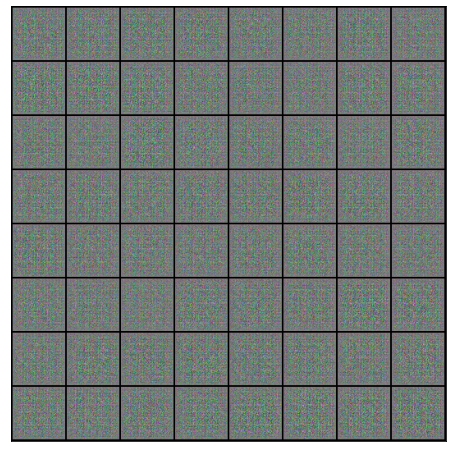

In [40]:
xb = torch.randn(batch_size, nz, 1, 1).to(device) # random latent tensors
fake_images = Generator_model(xb)
print(fake_images.shape)
show_images(fake_images)

In [41]:
#For discriminator training using binary cross entropy loss
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(Discriminator_model.parameters(), lr=0.0002,betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(Generator_model.parameters(), lr=0.0002,betas=(beta1, 0.999))

In [42]:
# utility function
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [43]:
#Train discriminator
def train_discriminator(images):
    real_labels = torch.ones(images.size(0), 1, device=device)
   
        
    # calculate loss on real image
    outputs = Discriminator_model(images)
    d_real_image_loss = criterion(outputs, real_labels)
    real_score = outputs

    # generate fake images and calculate loss on fake image
    z = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = Generator_model(z)
    fake_labels = torch.zeros(fake_images.size(0), 1, device=device)
    outputs = Discriminator_model(fake_images)
    d_fake_image_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    #loss addition
    d_total_loss = d_real_image_loss + d_fake_image_loss
    # set zero grad
    reset_grad()
    # backword
    d_total_loss.backward()
    # forword
    d_optimizer.step()
    
    return d_total_loss, real_score, fake_score


In [44]:
#Generator training

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, nz, 1,1, device=device)
    fake_images = Generator_model(z)
    labels = torch.ones(batch_size, 1, device=device)
    # Passing fake images and calculating loss on real label
    g_loss = criterion(Discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [45]:
import os
# Saving data to visiualization
sample_dir = 'dcgan_samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

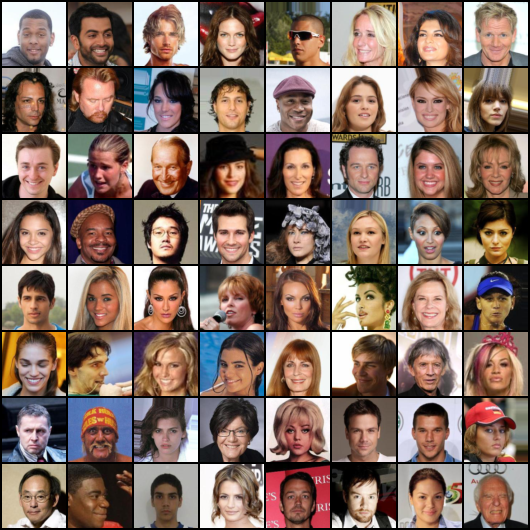

In [46]:
# Saving real images first
real_batch = next(iter(dataloader))

for images, _ in dataloader:
    save_image(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True), os.path.join(sample_dir, 'real_images.png'), nrow=8)
    break


In [47]:
def save_fake_images(index, latent_tensors, show=True):
  fake_images = Generator_model(latent_tensors)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [48]:
fixed_latent = torch.randn(64, nz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving fake_images-0000.png


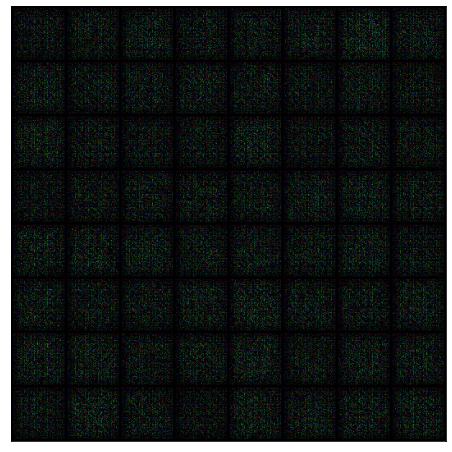

In [49]:
save_fake_images(0, fixed_latent)

In [50]:
%%time

#Training the model now and saving fake images in the folder
num_epochs = 50
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        # images = images.reshape(batch_size, -1).to(device)
        # real_cpu = images[0].to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images.to(device))
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item()) 
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1,fixed_latent,show=False)

Epoch [0/50], Step [200/1583], d_loss: 0.0001, g_loss: 42.4092, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [400/1583], d_loss: 0.0000, g_loss: 41.7175, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [600/1583], d_loss: 0.0000, g_loss: 41.4384, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [800/1583], d_loss: 0.0000, g_loss: 41.1680, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [1000/1583], d_loss: 0.0000, g_loss: 40.9011, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [1200/1583], d_loss: 0.0001, g_loss: 40.5431, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [1400/1583], d_loss: 0.0000, g_loss: 38.9939, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/50], Step [200/1583], d_loss: 0.7123, g_loss: 2.9320, D(x): 0.80, D(G(z)): 0.30
Epoch [1/50], Step [400/1583], d_loss: 1.0497, g_loss: 2.2324, D(x): 0.48, D(G(z)): 0.12
Epoch [1/50], Step [600/1583], d_loss: 1.0030, g_loss: 3.6343, D(x): 0.72, D(G(z)): 0.40
Epoch [1/50], Step [800/1583], d_loss: 0.6774, g_loss: 3.9023, D(x): 0.8

In [51]:
# Save the model checkpoints 
torch.save(Generator_model.state_dict(), 'G.ckpt')
torch.save(Discriminator_model.state_dict(), 'D.ckpt')

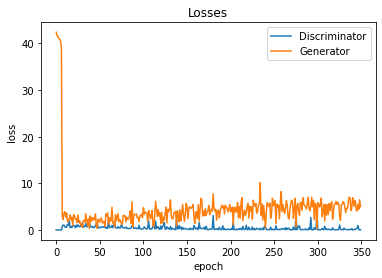

In [52]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

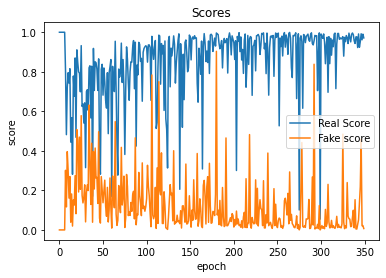

In [53]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [54]:
import glob
from PIL import Image

# filepaths
fp_in = "dcgan_samples/fake_images-*.png"
fp_out = "dcgan_samples/fake_image.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [55]:
from IPython.display import Image

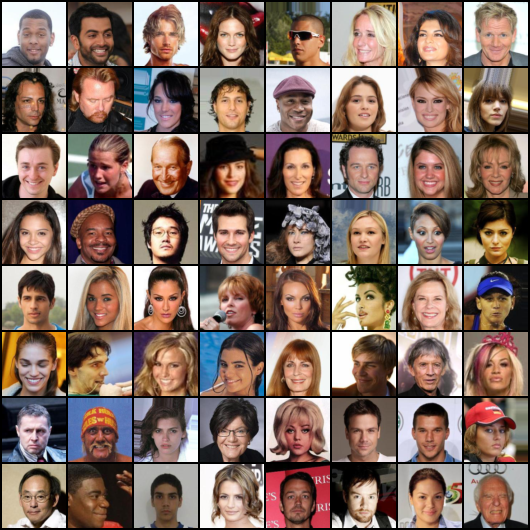

In [58]:
Image("dcgan_samples/real_images.png")

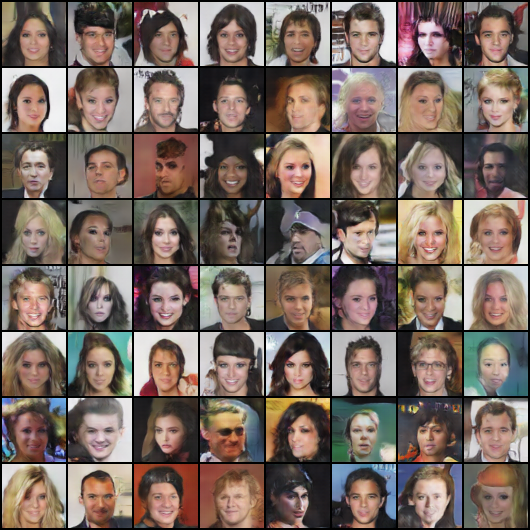

In [59]:
fake_fname = 'fake_images-{0:0=4d}.png'.format(num_epochs)
Image(os.path.join(sample_dir, fake_fname))